In [ ]:
!pip install voxelmorph > /dev/null

%cd "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration"
!ls

/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration
 affineRegNN5_data3.ipynb	  ImageReg.ipynb   requirements.txt
 affine_training_data_gen.ipynb   layers.py	   utils.py
 archived_notebook		  model_img	  'VoxelMorph Demo.ipynb'
 checkpoints			  MRNet		   vxm_data_gen.ipynb
 data				  __pycache__


In [ ]:
import os
import os.path as osp
import csv
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import pickle
import random
from termcolor import colored
import h5py, json # for load_voxelmorph
import itertools

# local imports for voxelmorph
import voxelmorph as vxm   # deep-learning based registration library
import neurite as ne       # medical image analysis with tensorflow

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

import layers as custom_layers

def color_print(string:str, color:str = "red"):
    print(colored(string, color))

def load_pickle(result_path):
    with open(result_path, "rb") as fin:
        return pickle.load(fin)

## Specify data path

In [ ]:
## Define dataset path
trainDataPath = "./data/affineTrainingData3/train/" #affine{}.npz
valDataPath = "./data/affineTrainingData3/val/"
testDataPath = "./data/affineTrainingData3/test/"
# val_size = 300 # 650
# test_size = 300 # 600

# include each real img once
train_path_list = [os.path.join(trainDataPath, item) for item in os.listdir(trainDataPath)][::5]
val_path_list = [os.path.join(valDataPath, item) for item in os.listdir(valDataPath)][::5]
test_path_list = [os.path.join(testDataPath, item) for item in os.listdir(testDataPath)][::5]

len(train_path_list), len(val_path_list), len(test_path_list)

(1000, 130, 120)

## Load affine module

In [ ]:
## Custom tf layer to convert separate affine parameters to the standard 12 params
#  tf layer tutorial: https://www.tensorflow.org/guide/keras/custom_layers_and_models#privileged_training_argument_in_the_call_method
class affine_rep2param(layers.Layer):
    """
    A custom layer to convert 21 affine transformation parameters
    to the 12 affine transformation parameters
    """
    def __init__(self, name="affine_rep2param", **kwargs):
        """
        arg:
            name
        """
        if name not in kwargs:
            kwargs.update({
                "trainable":False,
                "name":name,
            })
        super(self.__class__, self).__init__(**kwargs)
        self.rep_length = 21 

        # layer var, use Variable since tensor cannot do item assignment
        self.shearX_M = tf.Variable(initial_value=tf.eye(3), trainable=False, name=f"{self.name}/shearX_M")
        self.shearY_M = tf.Variable(initial_value=tf.eye(3), trainable=False, name=f"{self.name}/shearY_M")
        self.shearZ_M = tf.Variable(initial_value=tf.eye(3), trainable=False, name=f"{self.name}/shearZ_M")
    
    def build(self, input_shape):
        assert input_shape[1] == self.rep_length
        self.built = True
    
    def get_config(self):
        config = super().get_config().copy()
        return config
    
    def call(self, input, training=True):
        assert input.shape[1] == self.rep_length

        # convert affine rep to 12 params of affine transformation matrix
        if training: # have to separate the two cases since fn should only accepts one input
            return tf.map_fn(self.single_rep2param, input, fn_output_signature=tf.float32)#, parallel_iterations=batch_size)
        else: # using symmetric_orthogonalization
            return tf.map_fn(self.single_rep2param_svd, input, fn_output_signature=tf.float32)#, parallel_iterations=batch_size)
      
    def single_rep2param(self, rep):
        """
        convert a single affine representation of length-21 tensors to 
        affine parameters of length-12 tensors
        Args:
            rep: 21 param [21]
        """
        trans, rot, shear, scale = rep[0:3], rep[3:12], rep[12:18], rep[18:21]
        # affine_param = K.variable(lambda : K.ones((3,4))) # lambda for variable(): https://stackoverflow.com/questions/61579678/valueerror-tensor-typed-variable-initializers-must-either-be-wrapped-in-an-init
        # affine_param = affine_param[:, 3].assign(trans) # assign: https://stackoverflow.com/questions/57454529/how-to-assign-a-value-to-the-tensor-object-in-keras

        self.shearX_M[1:3, 0].assign(shear[:2])
        self.shearY_M[0, 1].assign(shear[2])
        self.shearY_M[2, 1].assign(shear[3])
        self.shearZ_M[0:2, 2].assign(shear[4:])
        affine_param = self.shearX_M @ self.shearY_M @ self.shearZ_M * scale

        affine_param = K.reshape(rot, (3,3)) @ affine_param
        affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
        return K.reshape(affine_param, shape=[-1])

    def single_rep2param_svd(self, rep):
        """
        convert a single affine representation of length-18 tensors to 
        affine parameters of length-12 tensors using symmetric_orthogonalization:
        https://github.com/google-research/google-research/tree/master/special_orthogonalization 
        """
        trans, rot, shear, scale = rep[0:3], rep[3:12], rep[12:18], rep[18:21]

        self.shearX_M[1:3, 0].assign(shear[:2])
        self.shearY_M[0, 1].assign(shear[2])
        self.shearY_M[2, 1].assign(shear[3])
        self.shearZ_M[0:2, 2].assign(shear[4:])
        affine_param = self.shearX_M @ self.shearY_M @ self.shearZ_M * scale

        ## symmetric orthogonalization
        rot = K.reshape(rot, (3,3))
        s,u,v = tf.linalg.svd(rot)
        vt = tf.transpose(tf.math.conj(v))
        det = tf.linalg.det(u @ vt)
        vt = tf.concat((vt[:2, :], vt[-1:, :] * det), axis=0) # flip last row if det=-1
        rot = u @ vt

        affine_param = rot @ affine_param
        affine_param = tf.concat([affine_param, trans[:, None]], axis = 1)
        return K.reshape(affine_param, shape=[-1])

In [ ]:
# Load model from experiment DLIR_2_21param_T5
affine_mdl_path = "checkpoints/DLIR_2_dataV3_21param/11_23_13-36-50/115.h5"
affine_model = keras.models.load_model(affine_mdl_path, custom_objects=
                {"SpatialTransformer":custom_layers.SpatialTransformer, # (interp_method='linear', add_identity=False, name="warped_image", shift_center=True)
                "affine_rep2param":affine_rep2param,
            })

Instructions for updating:
Use fn_output_signature instead


## Define vxm training dataloader

Use trained affine model to wrap real image pairs with possible hflip as training data pair for vxm model training. 

In [ ]:
train_path_list[:5]

['./data/affineTrainingData3/train/affine_800_0.npz',
 './data/affineTrainingData3/train/affine_801_0.npz',
 './data/affineTrainingData3/train/affine_802_0.npz',
 './data/affineTrainingData3/train/affine_803_0.npz',
 './data/affineTrainingData3/train/affine_804_0.npz']

In [ ]:
## code from image_reg.ipynb
def MSE(img1, img2):
    """ return MSE over all voxel of img in np.array"""
    return ((img1 - img2)**2).mean()

def affinely_wrap_img_w_hflip(affine_model, moving_test, fixed_img, vis=False, debug=False):
    """
    Predict the affinely wrapped image with the pretrained affine transformation 
    model. Horizontally flip the wrapped img if that has better MSE.
    Only consider hflip since it makes sence for knee MRI
    args:
        testModel: pretrained affine transformation model
        moving_test: input to the affine transformation model, [1, 64, 256, 256, 2] 
        fixed_img: the original img to be aligned with, [1, 64, 256, 256, 1]
    """
    # (warped_test, affine_pred_test) = affine_model(moving_test, training=False) # inference mode
    (warped_test, _) = affine_model(moving_test, training=False) # inference mode
    warped_test = warped_test.numpy()
    mse = MSE(fixed_img, warped_test)

    # try the flipped moving img
    moving_test2 = np.concatenate([moving_test[:,:,:,::-1, 0:1], fixed_img], axis=4) # flip moving in x
    (warped_test2, _) = affine_model(moving_test2, training=False) # inference mode
    warped_test2 = warped_test2.numpy()
    mse2 = MSE(fixed_img, warped_test2)
    if debug:
        print(f"mse1: {mse}, mse2: {mse2}")

    if vis:
        fixed_img_ = fixed_img[0, ... ,0]
        moving_test_ = moving_test[0, ... ,0]
        moving_test2_ = moving_test2[0, ... ,0]
        assert moving_test_.shape == (64,256,256)
        plt.imshow(fixed_img_[32])
        plt.show()
        plt.imshow(moving_test_[32])
        plt.show()
        plt.imshow(moving_test2_[32])
        plt.show()

    # compare mse score with fliping V.S. w/o fliping
    if mse2 < mse: # flipping initial moving image is better
        warped_test = warped_test2
    return warped_test

################################
## modified old version of data generator to also output sample name
def affine_wrapped_img_pair_generator(affine_model, input_path_list:list, batch_size:int=2, gt_trf_key="trf_21param", train=True):
    """
    out (wrapped moving, fixed, moving_name, fixed_name)
    Args:
        train: if randomly sample data
    """
    assert batch_size > 0
    ## all possible combination of 2
    all_comb_pair = list(itertools.combinations(input_path_list, 2))
    length = len(all_comb_pair)
    ind_list = np.arange(length)

    while True:
        if train:
            ind_list = np.random.permutation(length)
        for i in ind_list:
            # tick_for = time.time()
            path1, path2 = all_comb_pair[i]
            name1, name2 = path1.split("/")[-1].split("_")[1], path2.split("/")[-1].split("_")[1] # which real img
            inputObj1 = np.load(path1)
            img1 = inputObj1["movingImg"].astype("float32") # [1, 64, 256, 256, 1]
            inputObj2 = np.load(path2)
            img2 = inputObj2["movingImg"].astype("float32")
            # wrapped as moving for vxm
            # tick_before = time.time()
            wrapped_moving1_fixed2 = affinely_wrap_img_w_hflip(affine_model, np.concatenate([img1, img2], axis=-1), 
                                                               fixed_img=img2, vis=False, debug=False)
            # tick_mid = time.time()
            wrapped_moving2_fixed1 = affinely_wrap_img_w_hflip(affine_model, np.concatenate([img2, img1], axis=-1), 
                                                               fixed_img=img1, vis=False, debug=False)
            # tick_after = time.time()
            # print(tick_before-tick_for, tick_mid-tick_for, tick_after-tick_for)
            
            # wrapped_moving1_fixed2, _ = affine_model(np.concatenate([img1, img2], axis=-1), training=False) 
            # wrapped_moving2_fixed1, _ = affine_model(np.concatenate([img2, img1], axis=-1), training=False) 

            yield [wrapped_moving1_fixed2, img2, name1, name2]

            yield [wrapped_moving2_fixed1, img1, name2, name1]

0.9364702701568604 1.9709193706512451 2.9352457523345947
time used to gen 2 pair:  2.940523624420166


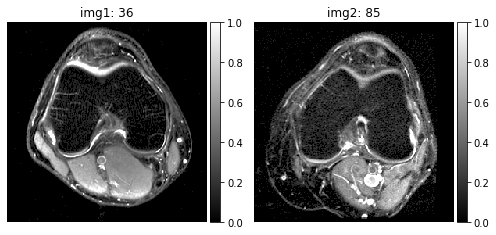

0.027827855


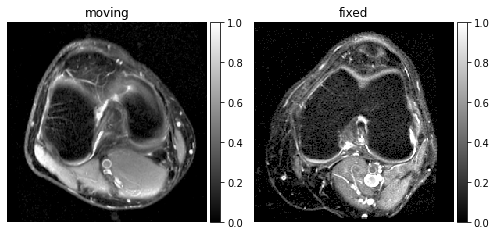

0.026692852


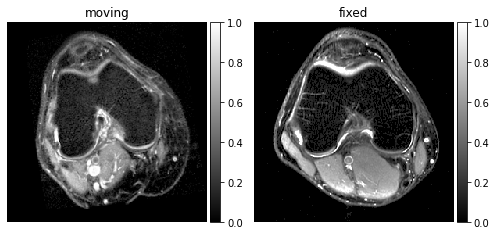

0.020657651


In [ ]:
# # test training generator
# tick = time.time()
# val_data_gen = affine_wrapped_img_pair_generator(affine_model, val_path_list, batch_size=1, gt_trf_key="trf_21param", train=True)
# wrapped_moving1_fixed2, img2, name1, name2 = next(val_data_gen)
# wrapped_moving2_fixed1, img1, name2, name1 = next(val_data_gen)
# print(f"time used to gen 2 pair:  {time.time() - tick}")
# middle_slice = affine_model.inputs[0].shape[1] // 2

# # visualize
# images = [img1[0, middle_slice, :, :, 0], img2[0, middle_slice, :, :, 0]] 
# titles = [f'img1: {name1}', f'img2: {name2}']
# ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=7);
# print(((img1 - img2)**2).mean() )

# # wrapped_moving1_fixed2 = wrapped_moving1_fixed2.numpy()
# images = [wrapped_moving1_fixed2[0, middle_slice, :, :, 0], img2[0, middle_slice, :, :, 0]] 
# titles = ['moving', 'fixed']
# ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=7);
# print(((wrapped_moving1_fixed2 - img2)**2).mean() )

# # wrapped_moving2_fixed1 = wrapped_moving2_fixed1.numpy()
# images = [wrapped_moving2_fixed1[0, middle_slice, :, :, 0], img1[0, middle_slice, :, :, 0]] 
# titles = ['moving', 'fixed']
# ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=7);
# print(((wrapped_moving2_fixed1 - img1)**2).mean() )

## Generate vxm training data

* For each real img pair, generate 2 pairs: 
    * img1 as moving + img2 as fixed 
    * img2 as moving + img1 as fixed 
* final size:
    * train: 4000
    * val: 300
    * test:  300
* since most pixel is 0, convert to uint8 to save space
    * < 40G

In [ ]:
## generate pairs of transformed images and real/moving img
def save_pair(moving1, img2, name1, name2, output_dir):
    assert type(moving1) == np.ndarray
    assert type(img2) == np.ndarray
    assert img2.shape == moving1.shape
    assert len(img2.shape) == 5
    assert len(moving1.shape) == 5
    
    path = os.path.join(output_dir, f"wrapped_moving{name1}_fixed{name2}.npz")
    moving1 = moving1*255
    img2 = img2*255
    with open(path, "wb") as f:
        np.savez(f, movingImg=moving1.astype(np.uint8),  fixedImg=img2.astype(np.uint8))

def generate_vxm_dataset(output_dir, affine_model, dataset_size, input_path_list:list, gt_trf_key="trf_21param"):
    assert dataset_size % 2 == 0

    data_gen = affine_wrapped_img_pair_generator(affine_model, input_path_list, batch_size=1, 
                                                 gt_trf_key=gt_trf_key, train=True)
    os.makedirs(output_dir, exist_ok=True)
    for i in tqdm(range(dataset_size//2)):
        wrapped_moving1_fixed2, img2, name1, name2 = next(data_gen)
        save_pair(wrapped_moving1_fixed2, img2, name1, name2, output_dir)
                
        wrapped_moving2_fixed1, img1, name2, name1 = next(data_gen)
        save_pair(wrapped_moving2_fixed1, img1, name2, name1, output_dir)

In [ ]:
len(train_path_list), len(val_path_list), len(test_path_list)

(1000, 130, 120)

In [ ]:
vxm_train_size = 4000
vxm_val_size = 300
vxm_test_size = 300
output_train_data_dir = "data/affinelyWrappedData/train"
output_val_data_dir = "data/affinelyWrappedData/val"
output_test_data_dir = "data/affinelyWrappedData/test"

In [ ]:
generate_vxm_dataset(output_train_data_dir, affine_model, vxm_train_size, train_path_list)
len(os.listdir(output_train_data_dir))

4000

In [ ]:
generate_vxm_dataset(output_val_data_dir, affine_model, vxm_val_size, val_path_list)
len(os.listdir(output_val_data_dir))

  0%|          | 0/150 [00:00<?, ?it/s]

300

In [ ]:
generate_vxm_dataset(output_test_data_dir, affine_model, vxm_test_size, test_path_list)
len(os.listdir(output_test_data_dir))

  0%|          | 0/150 [00:00<?, ?it/s]

300

### check generated data

In [ ]:
path = "data/train_axial/0000.npy"
inputObj = np.load(path)
inputObj.shape, inputObj.dtype

((44, 256, 256), dtype('uint8'))

data/affinelyWrappedData/test/wrapped_moving19_fixed1.npz


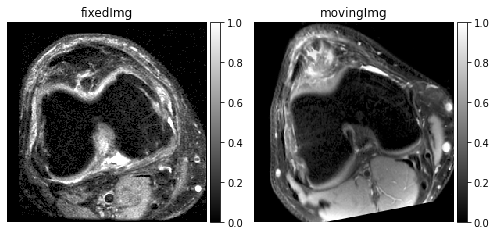

data/affinelyWrappedData/test/wrapped_moving2_fixed1.npz


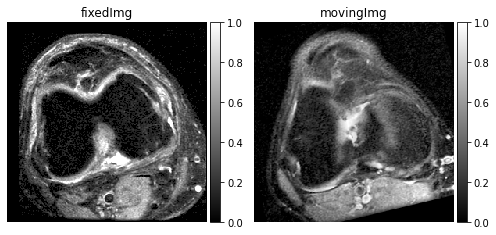

data/affinelyWrappedData/test/wrapped_moving97_fixed1.npz


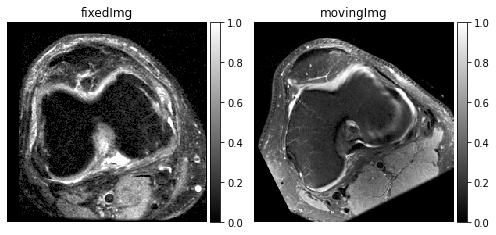

In [ ]:
# path = "data/affinelyWrappedData/val/wrapped_moving1_fixed84.npz"
val_dir = "data/affinelyWrappedData/test"
# for sample in os.listdir(val_dir)[:10]:
for sample in os.listdir(val_dir):
    if "fixed1." not in sample:
        continue
    sample_path = osp.join(val_dir, sample)
    print(sample_path)
    inputObj = np.load(sample_path)
    fixedImg = inputObj["fixedImg"].astype("float32") / 255
    movingImg = inputObj["movingImg"].astype("float32") / 255

    middle_slice=32
    images = [fixedImg[0, middle_slice, :, :, 0], movingImg[0, middle_slice, :, :, 0]] 
    titles = ['fixedImg', 'movingImg']
    ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, width=7);
    plt.show()